# Simulate both drift and start point biases

from Leite & Ratcliff (2011) -- What cognitive processes drive response biases? A diffusion model analysis:

"In the diffusion model, there are two ways to model response bias (Ratcliff, 1985; Ratcliff et al., 1999; Ratcliff & McKoon, 2008). One, analogous to the change in criterion threshold in SDT, involves a shift in the criterion that separates positive from negative drift rates. That is, one parameter (referred to as a “drift criterion” parameter, “dc”) produces an estimate of the amount to be added to or subtracted from the mean drift rates between conditions such that a null mean drift rate (a horizontal line starting at z in Figure 1.1) in an unbiased condition would be shifted to a positive or negative mean drift rate in a biased condition, for example. For small to moderate biases in drift rates, there are only small changes in the leading edges of the RT distributions between biased and unbiased conditions. The other way to model response bias involves moving the starting point of the diffusion process nearer the boundary toward which the responses are biased (Figure 1.1). This predicts a shorter leading edge of the RT distribution in the biased condition than in the unbiased condition (Ratcliff, 1985, 2002)."

Can we replicate this?

First, let's try this analytically!

In [39]:
from __future__ import division
import numpy as np
from scipy import integrate
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

In [40]:
def DDM(timepoints, v, a, z, Ter, eta, sz, st, s,):
    
    Ge = np.zeros(len(timepoints))
    Gc = np.zeros(len(timepoints))
    
    if eta == 0 and sz == 0:
        Pe = sim_Pe(v,a,z,s)
        for i, t in enumerate(timepoints):
            Ge[i] = sim_G(t,v,a,z,s,Pe)
            Gc[i] = sim_G(t,-v,a,a-z,s,1-Pe)
    
    if eta > 0 and sz == 0 and st == 0:
        x, w = lgwt(21,v-(4*eta),v+(4*eta))
        Fe = np.zeros(len(w))
        Fc = np.zeros(len(w))
        for i, t in enumerate(timepoints):
            for j in range(len(x)):
                Pe = sim_Pe(x[j],a,z,s)
                Fe[j] = sim_G(t,x[j],a,z,s,Pe)      *(1/np.sqrt(2*np.pi*(eta**2)))*(math.e**(-(((v-x[j])**2)/(2*(eta**2)))))
                Fc[j] = sim_G(t,-x[j],a,a-z,s,1-Pe) *(1/np.sqrt(2*np.pi*(eta**2)))*(math.e**(-(((v-x[j])**2)/(2*(eta**2)))))
            Ge[i] = np.sum(Fe*w)
            Gc[i] = np.sum(Fc*w)
    
    if eta == 0 and sz > 0 and st == 0:
        x, w = lgwt(21,z-(sz/2),z+(sz/2))
        Fe = np.zeros(len(w))
        Fc = np.zeros(len(w))
        for i, t in enumerate(timepoints):
            for j in range(len(x)):
                Pe = sim_Pe(v,a,x[j],s)
                Fe[j] = sim_G(t,v,a,x[j],s,Pe)      *(1/sz)
                Fc[j] = sim_G(t,-v,a,a-x[j],s,1-Pe) *(1/sz)
            Ge[i] = np.sum(Fe*w)
            Gc[i] = np.sum(Fc*w)
    
    if eta == 0 and sz == 0 and st > 0:
        Pe = sim_Pe(v,a,z,s)
        for i, t in enumerate(timepoints):
            x, w = lgwt(21,t-Ter-(st/2),t-Ter-(st/2))
            w[w<0] = 0
            Fe = np.zeros(len(w))
            Fc = np.zeros(len(w))
            for j in range(len(x)):
                Fe[j] = sim_G(x[j],v,a,z,s,Pe)      *(1/st)
                Fc[j] = sim_G(x[j],-v,a,a-z,s,1-Pe) *(1/st)
            Ge[i] = np.sum(Fe*w)
            Gc[i] = np.sum(Fc*w)
    
    
    return Gc, Ge

def sim_Pe(v,a,z,s):
    """
    function for estimating probability of an incorrect response given:
    v = drift rate
    a = boundary separation
    z = starting point
    s = noise
    """
    return (math.e**(-2*v*a/(s**2))-math.e**(-2*v*z/(s**2)))/(math.e**(-2*v*a/(s**2))-1)

def sim_G(t,v,a,z,s,Pe):

    """
    function for estimating probability of an incorrect response given:
    t = current time point (in seconds)
    v = drift rate
    a = boundary separation
    z = starting point
    s = noise
    Pe = probability of incorrect response
    """

    tol = 10e-29 # threshold for terminating sum component of equation
    sum_terms = [0]
    diff_terms= [1,1]
    k = 0
    while True:
        k += 1
        sum_terms.append(sum_terms[k-1] + ((2*k*np.sin(k*np.pi*z/a)*math.e**(-0.5*((((v**2)/(s**2))+((np.pi**2)*(k**2)*(s**2)/(a**2)))*t)))/(((v**2)/(s**2))+((np.pi**2)*(k**2)*(s**2)/(a**2)))))
        diff_terms.append( sum_terms[k] - sum_terms[k-1] )
        if (abs(diff_terms[k]) < (sum_terms[k-1]*tol)) and (abs(diff_terms[k-1]) < (sum_terms[k-2]*tol)):
            break
        
    return Pe-((((np.pi*(s**2))/(a**2))*math.e**(-(v*z/(s**2))))*sum_terms[k])

def lgwt(N,a,b):

    """
    This script is for computing definite integrals using Legendre-Gauss 
    Quadrature. Computes the Legendre-Gauss nodes and weights  on an interval
    [a,b] with truncation order N

    Suppose you have a continuous function f(x) which is defined on [a,b]
    which you can evaluate at any x in [a,b]. Simply evaluate it at all of
    the values contained in the x vector to obtain a vector f. Then compute
    the definite integral using sum(f.*w);

    Written by Greg von Winckel - 02/25/2004
    Translated to Python by JW de Gee - 2016.
    """
    
    # Params:
    N = N-1
    N1 = N+1
    N2 = N+2
    
    # Initial guess
    xu = np.linspace(-1,1,N1)
    y = np.cos((2*(np.arange(0,N+1))+1)*np.pi/(2*N+2))+(0.27/N1)*np.sin(np.pi*xu*N/N2)

    # Legendre-Gauss Vandermonde Matrix
    L_raw = np.zeros((N1,N2))

    # Derivative of LGVM
    Lp_raw = np.zeros((N1,N2))

    # Compute the zeros of the N+1 Legendre Polynomial
    # using the recursion relation and the Newton-Raphson method
    while True:
        L = L_raw.copy()
        L[:,0] = 1
        L[:,1] = y
        Lp = Lp_raw.copy()
        Lp[:,0] = 0
        Lp[:,1] = 1
        for k in range(2,N1+1):
            L[:,k] = ((2*k-1)*y*L[:,k-1]-(k-1)*L[:,k-2]) / k
        Lp = (N2)*( (L[:,N1-1]) - (y*L[:,N2-1]) )/(1-y**2)
        y0 = y.copy()
        y = y0 - (L[:,N2-1] / Lp)
        if max(abs(y-y0)) < np.spacing(1):
                break
    
    # Linear map from[-1,1] to [a,b]
    x = (a*(1-y)+b*(1+y)) / 2  

    # Compute the weights
    w = (b-a)/((1-y**2)*Lp**2)*(N2/N1)**2

    return x, w

In [41]:
# Set timing parameters
tmax = 4.0 # max RT (in seconds) to estimate first passage times to
dt = 0.01 # time step (in seconds)
timepoints = np.arange(dt,tmax,dt)

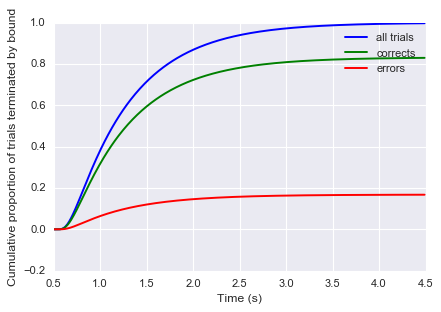

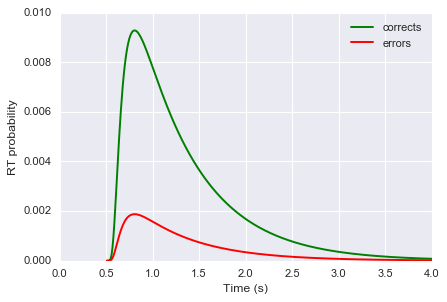

In [42]:
# Set parameters
v = 0.08   # drift rate
eta = 0    # drift rate variability
a = 0.2  # boundary separation
z = a / 2    # starting point
sz = 0     # starting point variability
Ter = 0.5  # non-decision time
st = 0
s = 0.1    # noise

# Estimate choice probabilities and defective cumulative probability distributions
Gc, Ge = DDM(timepoints,v,a,z,Ter,eta,sz,st,s)
RTe = np.diff(Ge)
RTc = np.diff(Gc)
  
plt.figure()
plt.plot(np.arange(dt,tmax,dt)+Ter, Gc+Ge, color='b', label='all trials')
plt.plot(np.arange(dt,tmax,dt)+Ter, Gc, color='g', label='corrects')
plt.plot(np.arange(dt,tmax,dt)+Ter, Ge, color='r', label='errors')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Cumulative proportion of trials terminated by bound')

plt.figure()
plt.plot(np.arange(dt,tmax,dt)[:-1]+Ter, RTc, color='g', label='corrects')
plt.plot(np.arange(dt,tmax,dt)[:-1]+Ter, RTe, color='r', label='errors')
plt.xlim(0,tmax)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('RT probability')

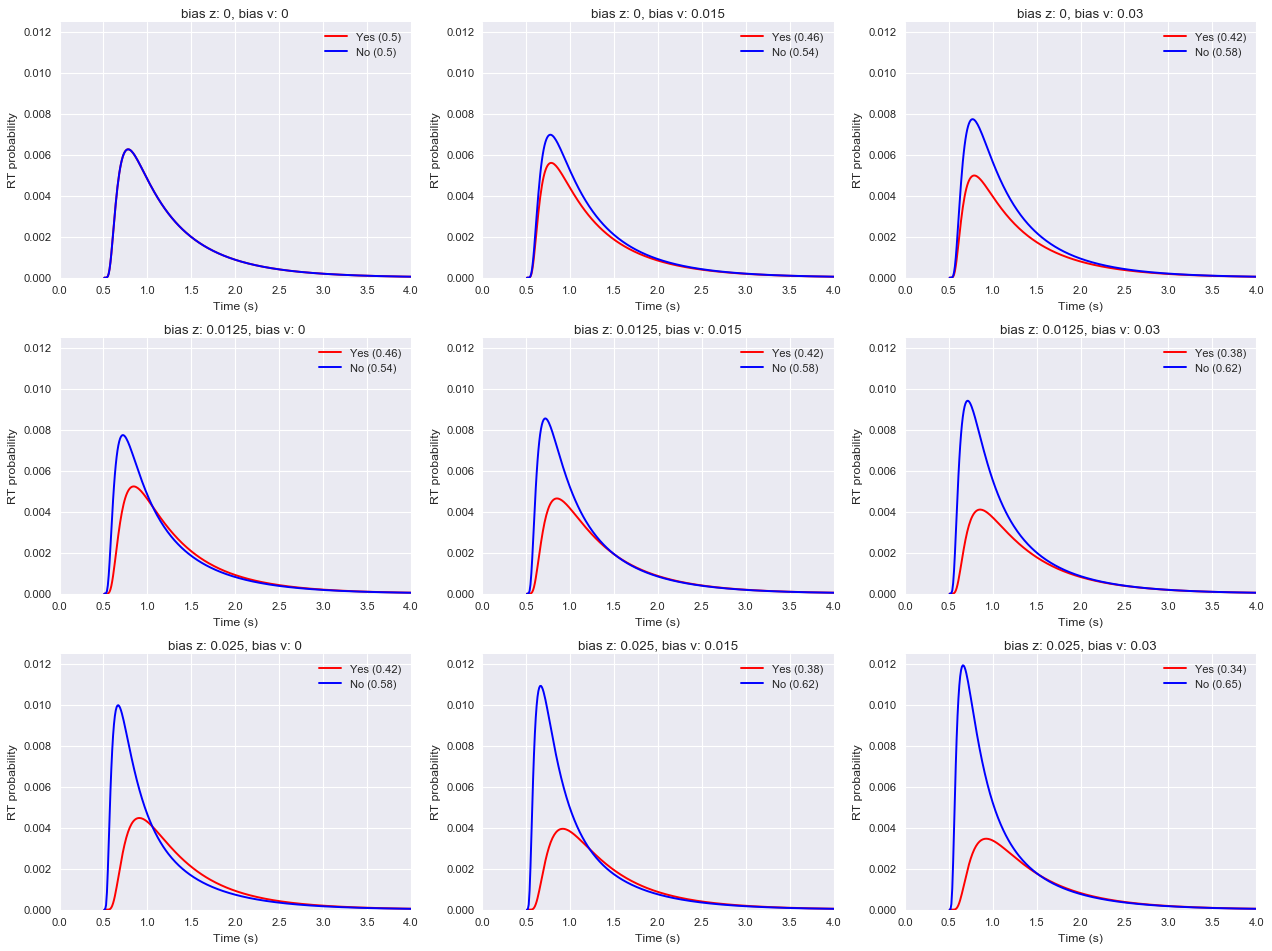

In [43]:
# Set parameters
v = 0.08   # drift rate
eta = 0.08    # drift rate variability
a = 0.2  # boundary separation
z = a / 2    # starting point
sz = 0     # starting point variability
Ter = 0.5  # non-decision time
s = 0.1    # noise

start_biases = [0, 0.0125, 0.025,]
drift_biases = [0, 0.015, 0.03,]

fig = plt.figure(figsize=(16,12))
plot_nr = 1
for start_bias in start_biases:
    for drift_bias in drift_biases:
        
        # Estimate choice probabilities and defective cumulative probability distributions
        Gc_with, Ge_against = DDM(timepoints,v+drift_bias,a,z+start_bias,Ter,eta,sz,st,s)
        Gc_against, Ge_with = DDM(timepoints,v-drift_bias,a,z-start_bias,Ter,eta,sz,st,s)
        
        RTe_with = np.diff(Ge_with)
        RTe_against = np.diff(Ge_against)
        RTc_with = np.diff(Gc_with)
        RTc_against = np.diff(Gc_against)
        
        RT_with = (RTc_with+RTe_with) / 2.0
        RT_against = (RTc_against+RTe_against) / 2.0
        
        plt.subplot(len(start_biases),len(drift_biases),plot_nr)
        plt.plot(np.arange(dt,tmax,dt)[:-1]+Ter, RT_against, 'red', label='Yes ({})'.format(round(sum(RT_against), 2)))
        plt.plot(np.arange(dt,tmax,dt)[:-1]+Ter, RT_with, 'blue', label='No ({})'.format(round(sum(RT_with), 2)))
        plt.ylim(0,0.0125)
        plt.xlim(0,tmax)
        plt.xlabel('Time (s)')
        plt.ylabel('RT probability')
        plt.title('bias z: {}, bias v: {}'.format(start_bias, drift_bias))
        plt.legend()
        plot_nr = plot_nr + 1
plt.tight_layout()
fig.savefig('bias_demo.pdf')

In [68]:
start_bias = 0
drift_bias = 0
Gc_with, Ge_against = DDM(timepoints,v+drift_bias,a,z+start_bias,Ter,eta,sz,st,s)
Gc_against, Ge_with = DDM(timepoints,v-drift_bias,a,z-start_bias,Ter,eta,sz,st,s)
RTe_with = np.diff(Ge_with)
RTe_against = np.diff(Ge_against)
RTc_with = np.diff(Gc_with)
RTc_against = np.diff(Gc_against)
RT_with_0 = (RTc_with+RTe_with) / 2.0
RT_against_0 = (RTc_against+RTe_against) / 2.0

start_bias = 0
drift_bias = 0.03
Gc_with, Ge_against = DDM(timepoints,v+drift_bias,a,z+start_bias,Ter,eta,sz,st,s)
Gc_against, Ge_with = DDM(timepoints,v-drift_bias,a,z-start_bias,Ter,eta,sz,st,s)
RTe_with = np.diff(Ge_with)
RTe_against = np.diff(Ge_against)
RTc_with = np.diff(Gc_with)
RTc_against = np.diff(Gc_against)
RT_with_1_dc = (RTc_with+RTe_with) / 2.0
RT_against_1_dc = (RTc_against+RTe_against) / 2.0

start_bias = 0
drift_bias = -0.03
Gc_with, Ge_against = DDM(timepoints,v+drift_bias,a,z+start_bias,Ter,eta,sz,st,s)
Gc_against, Ge_with = DDM(timepoints,v-drift_bias,a,z-start_bias,Ter,eta,sz,st,s)
RTe_with = np.diff(Ge_with)
RTe_against = np.diff(Ge_against)
RTc_with = np.diff(Gc_with)
RTc_against = np.diff(Gc_against)
RT_with_2_dc = (RTc_with+RTe_with) / 2.0
RT_against_2_dc = (RTc_against+RTe_against) / 2.0

start_bias = 0.025
drift_bias = 0
Gc_with, Ge_against = DDM(timepoints,v+drift_bias,a,z+start_bias,Ter,eta,sz,st,s)
Gc_against, Ge_with = DDM(timepoints,v-drift_bias,a,z-start_bias,Ter,eta,sz,st,s)
RTe_with = np.diff(Ge_with)
RTe_against = np.diff(Ge_against)
RTc_with = np.diff(Gc_with)
RTc_against = np.diff(Gc_against)
RT_with_1_z = (RTc_with+RTe_with) / 2.0
RT_against_1_z = (RTc_against+RTe_against) / 2.0

start_bias = -0.025
drift_bias = 0
Gc_with, Ge_against = DDM(timepoints,v+drift_bias,a,z+start_bias,Ter,eta,sz,st,s)
Gc_against, Ge_with = DDM(timepoints,v-drift_bias,a,z-start_bias,Ter,eta,sz,st,s)
RTe_with = np.diff(Ge_with)
RTe_against = np.diff(Ge_against)
RTc_with = np.diff(Gc_with)
RTc_against = np.diff(Gc_against)
RT_with_2_z = (RTc_with+RTe_with) / 2.0
RT_against_2_z = (RTc_against+RTe_against) / 2.0

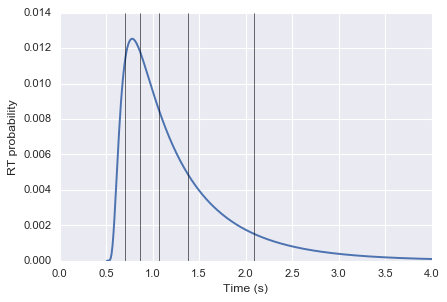

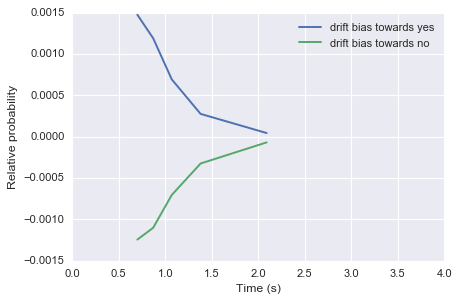

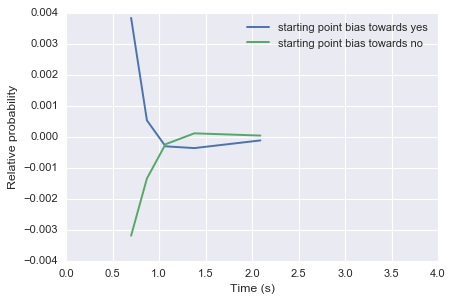

In [72]:
RT_full = RT_with_0 + RT_against_0
quintiles = (np.array([np.where(np.cumsum(RT_full) > q)[0][0] for q in [0.1, 0.3, 0.5, 0.7, 0.9]]) / 100.0 )
plt.plot(np.arange(dt,tmax,dt)[:-1]+Ter, RT_full)
for q in quintiles:
    plt.axvline(q+Ter, color='k', lw=0.5)
plt.xlim(0,tmax)
plt.xlabel('Time (s)')
plt.ylabel('RT probability')

probs_1_z = np.array([RT_with_1_z[q] - RT_against_0[q] for q in np.array(quintiles*100, dtype=int)])
probs_2_z = np.array([RT_with_2_z[q] - RT_against_0[q] for q in np.array(quintiles*100, dtype=int)])
probs_1_dc = np.array([RT_with_1_dc[q] - RT_against_0[q] for q in np.array(quintiles*100, dtype=int)])
probs_2_dc = np.array([RT_with_2_dc[q] - RT_against_0[q] for q in np.array(quintiles*100, dtype=int)])

plt.figure()
plt.plot(quintiles+Ter, probs_1_dc, label='drift bias towards yes')
plt.plot(quintiles+Ter, probs_2_dc, label='drift bias towards no')
plt.legend()
plt.xlim(0,tmax)
plt.xlabel('Time (s)')
plt.ylabel('Relative probability')

plt.figure()
plt.plot(quintiles+Ter, probs_1_z, label='starting point bias towards yes')
plt.plot(quintiles+Ter, probs_2_z, label='starting point bias towards no')
plt.legend()
plt.xlim(0,tmax)
plt.xlabel('Time (s)')
plt.ylabel('Relative probability')